Tutorial from: https://www.kaggle.com/code/anushkaml/spam-or-ham-sms-email-classifier

**Initial** Setup

In [31]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

In [32]:
from google.colab import files
df = pd.read_csv('../Data/spam.csv', encoding = "ISO-8859-1")
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
4437,ham,Nothing will ever be easy. But don't be lookin...,NaN,NaN,NaN
150,ham,The wine is flowing and i'm i have nevering..,NaN,NaN,NaN
1667,ham,So now my dad is gonna call after he gets out ...,NaN,NaN,NaN
5269,spam,"If you don't, your prize will go to another cu...",NaN,NaN,NaN
919,ham,Dont talk to him ever ok its my word.,NaN,NaN,NaN


In [33]:
df.shape

(5572, 5)

Data Cleaning:

Dropping non-useful/redundant columns
Label Encoding our data - 0:ham and 1:spam
Null values analysis
Duplicate values analysis etc.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [35]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True) # drop last 3 cols as they don't make enough sense
df.sample(5)

,v1,v2
452,ham,K:)k:)what are detail you want to transfer?acc...
4718,ham,Aiyo... Her lesson so early... I'm still sleep...
4271,ham,Where to get those?
820,ham,Good afternoon starshine! How's my boytoy? Doe...
5293,ham,I donno its in your genes or something


In [36]:
# renaming the cols
df.rename(columns={'v1':'target','v2':'text'},inplace=True)
df.sample(5)

,target,text
2646,ham,"Em, its olowoyey@ usc.edu have a great time in..."
4829,ham,"The word \Checkmate\"" in chess comes from the ..."
1002,ham,Yes..he is really great..bhaji told kallis bes...
3478,ham,Be sure to check your yahoo email. We sent pho...
1181,ham,You flippin your shit yet?


In [37]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

df['target'] = encoder.fit_transform(df['target'])

df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [38]:
# missing values
df.isnull().sum()

target    0
text      0
dtype: int64

In [39]:
# check for duplicate values and delete them
print("delete ", df.duplicated().sum(), "duplicates...")
df = df.drop_duplicates(keep='first')
print("Remaining duplicates: ",df.duplicated().sum())

delete  403 duplicates...
Remaining duplicates:  0


Data Exploration:

In [40]:
df.shape

(5169, 2)

In [41]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [42]:
df['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

Data Imbalance Check:

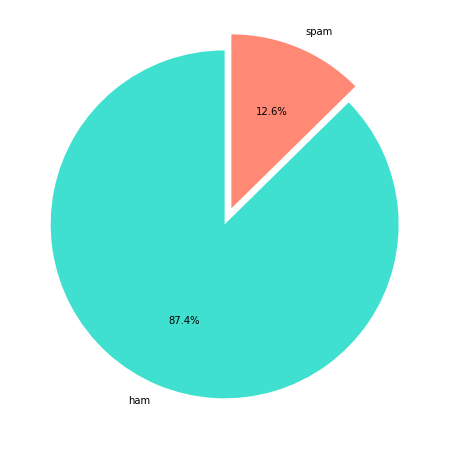

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.pie(df['target'].value_counts(), labels=['ham','spam'], autopct='%1.1f%%', colors = ['turquoise','#ff8975'], startangle=90, explode = (0, 0.1))
plt.show()

Data is clearly imbalanced ... TODO: So what now? And why? because it should be 40 / 60 like regarding official numbers from 2020???

Feature Engineering:

In [44]:
import nltk
nltk.download('punkt')

df['num_characters'] = df['text'].apply(len)

# num of words
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

# num of sentences
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [45]:
# ham
df[df['target'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,16.957484,1.815545
std,56.358207,13.394052,1.364098
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,219.000000,38.000000


In [46]:
import seaborn as sns

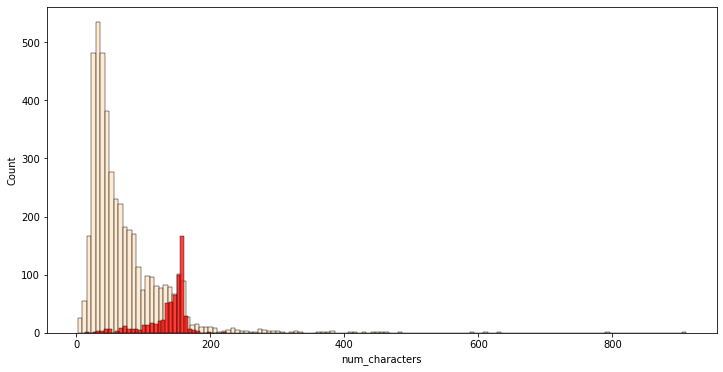

In [47]:
##distribution of spam and ham characters

plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_characters'], color = 'bisque')
sns.histplot(df[df['target'] == 1]['num_characters'],color='red')
plt.show()

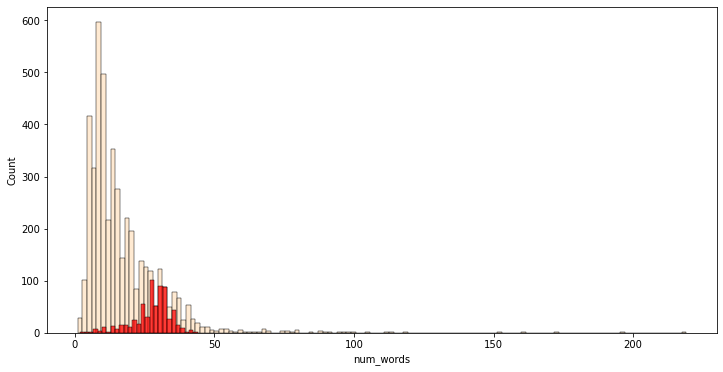

In [48]:
#distribution of spam and ham words

plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_words'],color='bisque')
sns.histplot(df[df['target'] == 1]['num_words'],color='red')
plt.show()

Outliner Detection:

<Figure size 1008x432 with 0 Axes>

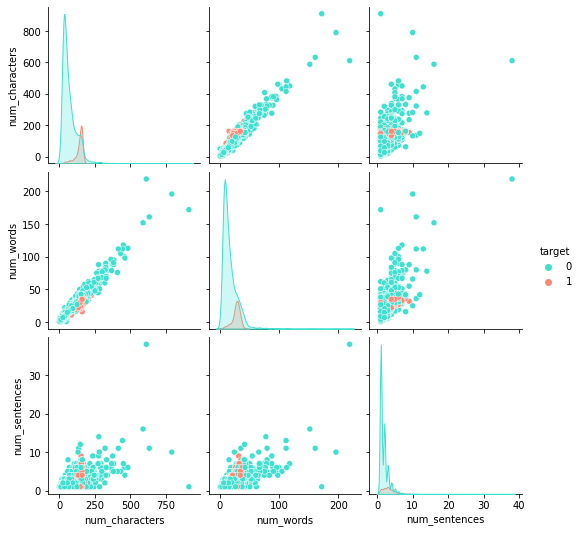

In [49]:
#pairplot
plt.figure(figsize=(14,6))
cols= ['turquoise','#ff8975']
sns.pairplot(df,hue='target',palette=cols)
plt.show()

Observations:
Clear presence of outliers in our data. Also since each of those attributes specify length of a given text, they are likely to be correlated as well.

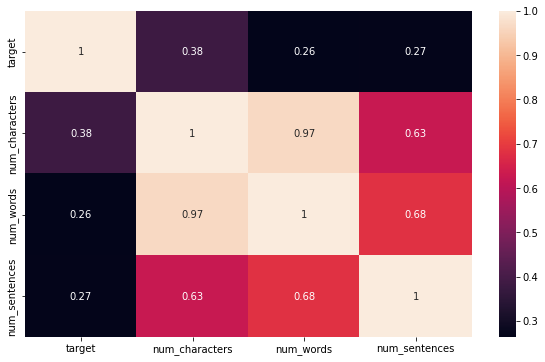

In [50]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),annot=True)
plt.show()

Extreme correlation between num_words and num_characters. Same goes for num_words and num_sentences

So we need to consider just one of these three - preferrably num_characters for our model!

Data preprocessing:

In [53]:
#lowercase, tokenization, special chars/punctualtion and stopwords removal

from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
import string

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    #retaining only numbers and alphabets
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    #clone copy of list y
    text = y[:]
    y.clear()

    #stopwords removal
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    #stemming
    for i in text:
        y.append(ps.stem(i))


    return " ".join(y)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [54]:
#Test preprocessing
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [55]:
df['transformed_text'] = df['text'].apply(transform_text)
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2,go jurong point avail bugi n great world la e ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [56]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2,go jurong point avail bugi n great world la e ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


View frequent words in our data post text preprocessing

In [57]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [58]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

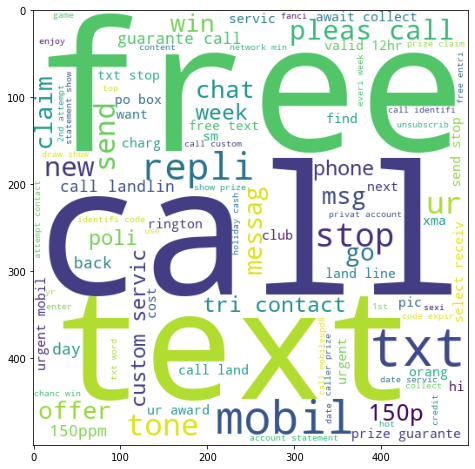

In [59]:
plt.figure(figsize=(20,8))
plt.imshow(spam_wc)
plt.show()


Stopwords in Ham messages

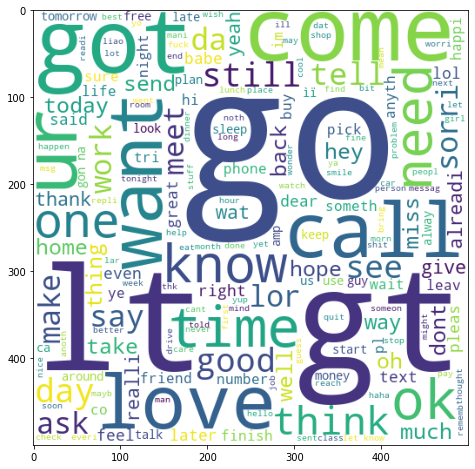

In [60]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

plt.figure(figsize=(20,8))
plt.imshow(ham_wc)
plt.show()

In [61]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2,go jurong point avail bugi n great world la e ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [62]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [63]:
len(spam_corpus)

9883

So we have a total of around 10k words in our spam corpus.
Let's view the number top 30 most occurring words in Spam and Ham corpus

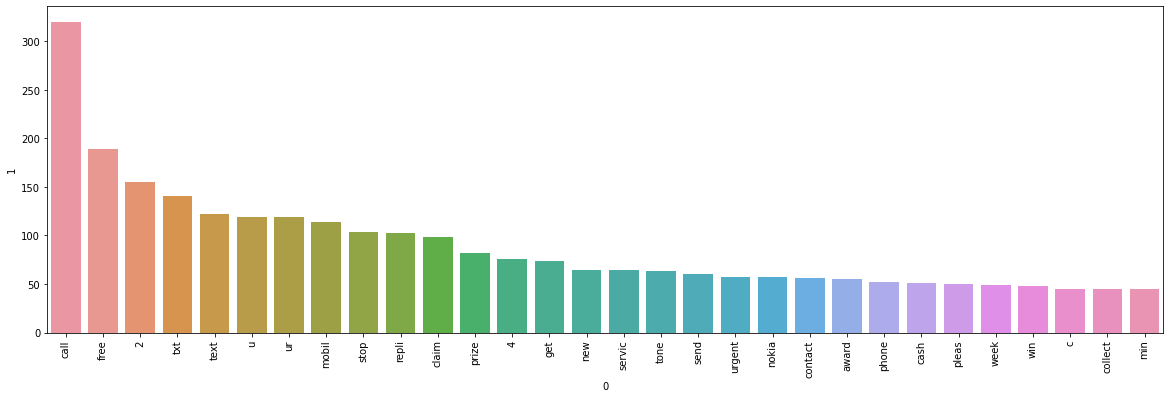

In [64]:
warnings.filterwarnings('ignore')

#using counter to keep a count of each word in corpus
from collections import Counter
plt.figure(figsize=(20,6))
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(30))[0],pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

Top 30 words in Ham corpus

In [65]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [66]:
len(ham_corpus)

34771

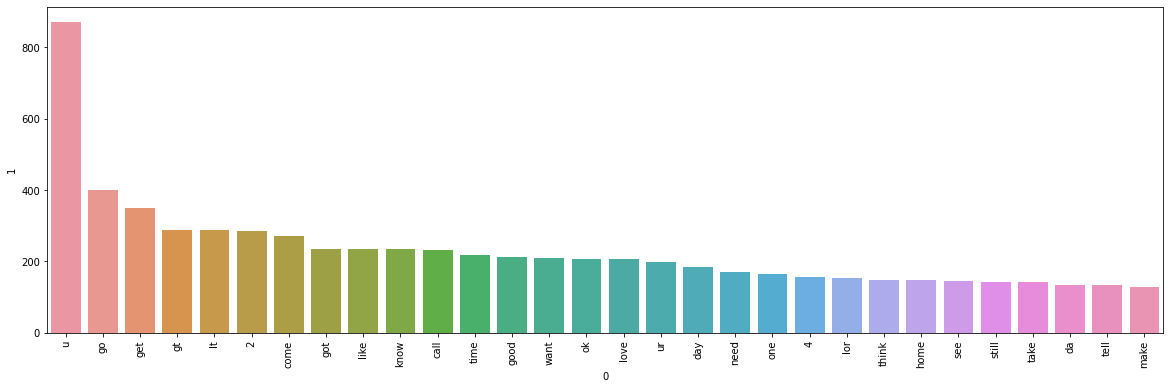

In [67]:
from collections import Counter
plt.figure(figsize=(20,6))
sns.barplot(pd.DataFrame(Counter(ham_corpus).most_common(30))[0],pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

# Vectorization

So we need to covert our text to vectors for machine to understand. We made use of both BOW and TFIDF and found that TFIDF  performs better.

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

In [68]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv = CountVectorizer()

##tfidf = TfidfVectorizer

#Setting max_features t0 3000 here after tring multiple random values this ones shows best results
tfidf = TfidfVectorizer(max_features=3000)

In [69]:
X = tfidf.fit_transform(df['transformed_text']).toarray()

In [70]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2,go jurong point avail bugi n great world la e ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


# Model Building

**Steps: **
Setting X and y (target)
Splitting the testing and training sets (20:80)
We will start with Naive Bayes as it is proven to give best results on Textual data
Build a pipeline of model for multiple ML algorithms.
Fit all the models on training data
Get the cross-validation on the training set for all the models for accuracy

**Models:**

Multinomial Naïve Bayes <br>
RandomForestClassifier<br>
KNeighborsClassifier<br>
Support Vector Machines<br>
LogisticRegression<br>
DecisionTreeClassifier<br>
AdaBoostClassifier<br>
BaggingClassifier<br>
ExtraTreesClassifier<br>
GradientBoostingClassifier<br>
XGBClassifier<br>

Note : Our model evaluation metric won't be accuracy here as the dataset is imbalanced. We will consider Precision more important than accuravy!

In [71]:
X.shape

(5169, 3000)

In [72]:
y = df['target'].values

**Train-Test split:**

In [74]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

**Model 1 Naive Bayes**

We will perform GaussianNB, MultinomialNB and BernoulliNB as Naive Bayes is proven to perform the best on textual data

In [77]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [78]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

**Guassian NB**

In [79]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.867504835589942
[[785 111]
 [ 26 112]]
0.5022421524663677


**Multinomial NB**

In [80]:
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.9729206963249516
[[896   0]
 [ 28 110]]
1.0


**BernoulIi NB**

In [81]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.9816247582205029
[[895   1]
 [ 18 120]]
0.9917355371900827


BEST RESULTS SO FAR

SO WE GET a great model with combination: 

tfidf --> MNB
and 
tfidf --> BNB

Pipeline - OTHER MODELS 

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [83]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc =  BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt =GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

Note :
ExtraTreesClassifier
This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

# Model Evaluation

In [84]:
# DICTIONARY OF CLASSIFIERS

clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'XGB':xgb
}

In [85]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    #train_accuracy = accuracy_score(X_train, y_train)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    
    return accuracy,precision,f1,recall

In [86]:
#train_classifier(svc,X_train,y_train,X_test,y_test)


In [87]:
accuracy_scores = []
precision_scores = []
f1_scores = []
recall_scores = []

for name,clf in clfs.items():
    
    current_accuracy, current_precision, f1_score, recall_score = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("\nFor classifier ",name, ":")

    print("  Test_Accuracy - ",current_accuracy)
    print("  Precision - ", current_precision)
    print("  F1 Score - ", f1_score)
    print("  Recall - ",recall_score)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    f1_scores.append(f1_score)
    recall_scores.append(recall_score)


For classifier  SVC :
  Test_Accuracy -  0.9748549323017408
  Precision -  0.9666666666666667
  F1 Score -  0.8992248062015503
  Recall -  0.8405797101449275

For classifier  KN :
  Test_Accuracy -  0.9052224371373307
  Precision -  1.0
  F1 Score -  0.44943820224719105
  Recall -  0.2898550724637681

For classifier  NB :
  Test_Accuracy -  0.9729206963249516
  Precision -  1.0
  F1 Score -  0.8870967741935484
  Recall -  0.7971014492753623

For classifier  DT :
  Test_Accuracy -  0.9342359767891683
  Precision -  0.85
  F1 Score -  0.7142857142857143
  Recall -  0.6159420289855072

For classifier  LR :
  Test_Accuracy -  0.9574468085106383
  Precision -  0.9519230769230769
  F1 Score -  0.8181818181818182
  Recall -  0.717391304347826

For classifier  RF :
  Test_Accuracy -  0.971953578336557
  Precision -  0.9739130434782609
  F1 Score -  0.8853754940711462
  Recall -  0.8115942028985508

For classifier  AdaBoost :
  Test_Accuracy -  0.9642166344294004
  Precision -  0.9316239316239

In [88]:
performance_df = pd.DataFrame(
    {'Algorithm':clfs.keys(),
     'Test_Accuracy':accuracy_scores,
     'Precision':precision_scores,
     'Recall':recall_scores,
     'F1_Score':f1_scores}
    ).sort_values('Precision',ascending=False)

In [89]:
cmap2 = ListedColormap(['turquoise','#ff8975'])
performance_df.style.background_gradient(cmap=cmap2)

,Algorithm,Test_Accuracy,Precision,Recall,F1_Score
1,KN,0.905222,1.000000,0.289855,0.449438
2,NB,0.972921,1.000000,0.797101,0.887097
8,ETC,0.977756,0.983193,0.847826,0.910506
5,RF,0.971954,0.973913,0.811594,0.885375
0,SVC,0.974855,0.966667,0.840580,0.899225
4,LR,0.957447,0.951923,0.717391,0.818182
10,XGB,0.946809,0.946237,0.637681,0.761905
6,AdaBoost,0.964217,0.931624,0.789855,0.854902
9,GBDT,0.948743,0.929293,0.666667,0.776371
7,BgC,0.954545,0.852713,0.797101,0.823970


BEST PERFORMANCE AMOUNG ALL CONSIDERING PRECISION - NB and KN

Overall best performance - NB, ETC , SVC and RF

In [90]:
performance_df

,Algorithm,Test_Accuracy,Precision,Recall,F1_Score
1,KN,0.905222,1.000000,0.289855,0.449438
2,NB,0.972921,1.000000,0.797101,0.887097
8,ETC,0.977756,0.983193,0.847826,0.910506
5,RF,0.971954,0.973913,0.811594,0.885375
0,SVC,0.974855,0.966667,0.840580,0.899225
4,LR,0.957447,0.951923,0.717391,0.818182
10,XGB,0.946809,0.946237,0.637681,0.761905
6,AdaBoost,0.964217,0.931624,0.789855,0.854902
9,GBDT,0.948743,0.929293,0.666667,0.776371
7,BgC,0.954545,0.852713,0.797101,0.823970


In [92]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")

Note :
Pandas melt() function is used to change the DataFrame format from wide to long. It's used to create a specific format of the DataFrame object where one or more columns work as identifiers. All the remaining columns are treated as values and unpivoted to the row axis and only two columns – variable and value.

In [93]:
performance_df1

,Algorithm,variable,value
0,KN,Test_Accuracy,0.905222
1,NB,Test_Accuracy,0.972921
2,ETC,Test_Accuracy,0.977756
3,RF,Test_Accuracy,0.971954
4,SVC,Test_Accuracy,0.974855
5,LR,Test_Accuracy,0.957447
6,XGB,Test_Accuracy,0.946809
7,AdaBoost,Test_Accuracy,0.964217
8,GBDT,Test_Accuracy,0.948743
9,BgC,Test_Accuracy,0.954545


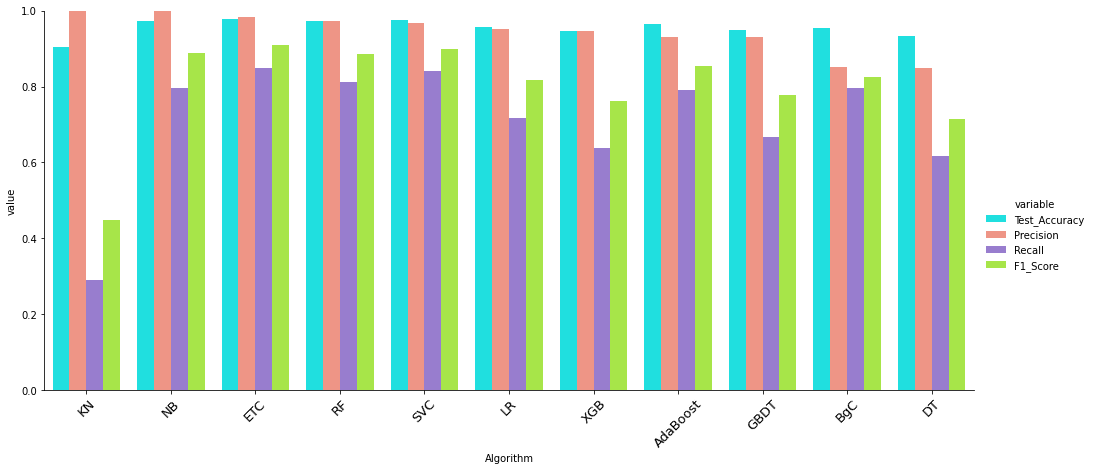

In [94]:
cols = cols= ['cyan','#ff8975', 'mediumpurple','greenyellow'] 
plt = sns.catplot(x = 'Algorithm', y='value', 
               hue = 'variable',data=performance_df1, kind='bar',height=6, palette = cols, aspect=2.3)


plt.set(ylim=(0,1.0))
for axes in plt.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, size=13)

# Model Improvement

1. Change the max_features parameter of TfIdf to 3000

In [95]:
temp_df = pd.DataFrame(
    {'Algorithm':clfs.keys(),
     'Accuracy_max_ft_3000':accuracy_scores,
     'Precision_max_ft_3000':precision_scores}
     ).sort_values('Precision_max_ft_3000',ascending=False)

In [96]:
temp_df = pd.DataFrame(
    {'Algorithm':clfs.keys(),
     'Accuracy_scaling':accuracy_scores,
     'Precision_scaling':precision_scores}
     ).sort_values('Precision_scaling',ascending=False)

In [97]:
new_df = performance_df.merge(temp_df,on='Algorithm')

2. Try min_max scaler

In [98]:
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#X = scaler.fit_transform(X)

In [99]:
# appending the num_character col to X
#X = np.hstack((X,df['num_characters'].values.reshape(-1,1)))

In [100]:
new_df_scaled = new_df.merge(temp_df,on='Algorithm')

In [101]:
temp_df = pd.DataFrame(
    {'Algorithm':clfs.keys(),
     'Accuracy_num_chars':accuracy_scores,
     'Precision_num_chars':precision_scores}
     ).sort_values('Precision_num_chars',ascending=False)

In [102]:
new_df_scaled.merge(temp_df,on='Algorithm')

,Algorithm,Test_Accuracy,Precision,Recall,F1_Score,Accuracy_scaling_x,Precision_scaling_x,Accuracy_scaling_y,Precision_scaling_y,Accuracy_num_chars,Precision_num_chars
0,KN,0.905222,1.000000,0.289855,0.449438,0.905222,1.000000,0.905222,1.000000,0.905222,1.000000
1,NB,0.972921,1.000000,0.797101,0.887097,0.972921,1.000000,0.972921,1.000000,0.972921,1.000000
2,ETC,0.977756,0.983193,0.847826,0.910506,0.977756,0.983193,0.977756,0.983193,0.977756,0.983193
3,RF,0.971954,0.973913,0.811594,0.885375,0.971954,0.973913,0.971954,0.973913,0.971954,0.973913
4,SVC,0.974855,0.966667,0.840580,0.899225,0.974855,0.966667,0.974855,0.966667,0.974855,0.966667
5,LR,0.957447,0.951923,0.717391,0.818182,0.957447,0.951923,0.957447,0.951923,0.957447,0.951923
6,XGB,0.946809,0.946237,0.637681,0.761905,0.946809,0.946237,0.946809,0.946237,0.946809,0.946237
7,AdaBoost,0.964217,0.931624,0.789855,0.854902,0.964217,0.931624,0.964217,0.931624,0.964217,0.931624
8,GBDT,0.948743,0.929293,0.666667,0.776371,0.948743,0.929293,0.948743,0.929293,0.948743,0.929293
9,BgC,0.954545,0.852713,0.797101,0.823970,0.954545,0.852713,0.954545,0.852713,0.954545,0.852713


No major improvement after scaling the features. But after setting max_feature = 3000, we did observe a better accuracy and precision



3. Use voting and stacking classifiers (combination of best performing model

In [103]:
# Voting Classifier
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

from sklearn.ensemble import VotingClassifier

In [104]:
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('et', etc)],voting='soft')

In [105]:
voting.fit(X_train,y_train)

VotingClassifier(estimators=[('svm',
                              SVC(gamma=1.0, kernel='sigmoid',
                                  probability=True)),
                             ('nb', MultinomialNB()),
                             ('et',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=2))],
                 voting='soft')

In [106]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9796905222437138
Precision 0.975609756097561


Try Stacking classifier with NB, SVM and ETC combination

In [107]:
# Applying stacking
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator=RandomForestClassifier()

In [108]:
from sklearn.ensemble import StackingClassifier

In [109]:
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [110]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9787234042553191
Precision 0.9393939393939394


No significant improvement in performance post voting and stacking classifiers.

# Final Model

Hence we will use our Multinomial NAIVE BAYES as our final model as it has the best combination of precision and accuracy

In [111]:
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))

Out of multiple classifers tried, we finally went with Multinomial Naive Bayes based on the evaluation metrics : Precision and Accuracy (on test data)

Note:
For us, a higher value of False Positive will be the worst case scenario as non-spam emails getting classified as "Spam" can result in real damage. Hence in order to ensure minimum False Positive implies that we need to have a Higher Precision value and that's what makes Precision the most important Evaluation Metric for us.

Hence we went ahead with the model with offered 100% Precision score with 97% Accuracy o our test data!

In [ ]:
# TODO: implement feature to predict output of user input 